In [8]:
import numpy as np
import scipy as sp 
from matplotlib import pyplot as plt

In [99]:
# define relevant constants
n = 1000
sigma_2 = 0.5
sigma = np.sqrt(sigma_2)
m = 15
k = 10

In [83]:
#helpful functions!
def designmatrix(x_input,m):
    X = np.vstack([np.ones(np.size(x_input))]).T
    for i in range(m):
        X = np.vstack([X.T, x_input**(i+1)]).T
    return X
def designvector(x_input,m):
    dvector = np.vstack([1]).T
    for i in range(m):
        dvector = np.vstack([dvector.T, x_input**(i+1)]).T
    return dvector

In [100]:
# generate sample data 
noise = np.random.normal(0,sigma,n)
x = np.random.uniform(-1,1,size=n)
y = np.sin(2*np.pi*x) + noise

In [101]:
avg_bias_2, avg_variance, avg_testMSE, avg_trainMSE  = np.zeros(m),  np.zeros(m),  np.zeros(m), np.zeros(m)

for p in range(m):
    testMSE = np.zeros(k)
    trainMSE = np.zeros(k)
    
    X = designmatrix(x, p+1)
    
    #iterate over the k-fold set
    for i in range(k):
        
        #split data using k-blocks, taking the i-th for testing and the rest for training.
        x_train = np.concatenate((x[0:100*i], x[100*(i+1):1000]))
        y_train = np.concatenate((y[0:100*i], y[100*(i+1):1000]))
        x_test = x[100*i:100*(i+1)]
        y_test = y[100*i:100*(i+1)]
        
        #design matrices
        X_train = designmatrix(x_train, p+1)
        X_test = designmatrix(x_test, p+1)
        
        #compute coefficients
        w = np.linalg.lstsq(X_train,y_train, rcond=None)[0]
        
        #store coefficients
        if (i == 0):
            mw = w
        else:
            mw = np.vstack([mw.T, w]).T
        
        #compute MSE
        testMSE[i] = (1 / len(x_test)) * sum((y_test - X_test @ w)**2)
        #trainMSE[i] = (1 / len(x_train)) * sum((y_train - X_train @ w)**2)
    
    #compute bias using formula
    average_model = np.average(mw,axis=1)
    avg_bias_2[p] = (1 / len(x)) * sum((X @ average_model - np.sin(2*np.pi*x))**2)
    
    variance = 0
    for x_value in x_test:
        inner = 0
        for model_index in range(k): 
            inner = inner + (designvector(x_value, p+1) @ mw[:,model_index] - designvector(x_value, p+1) @ average_model)**2
        variance = variance + inner / k
        
    #should be divided by N, no?
    avg_variance[p] = variance #/ len(x_test)
    
    avg_testMSE[p] = np.average(testMSE)
    #avg_trainMSE[p] = np.average(trainMSE)


C:\Users\asaha1203\AppData\Local\Temp\ipykernel_184392\1067654457.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  avg_variance[p] = variance #/ len(x_test)


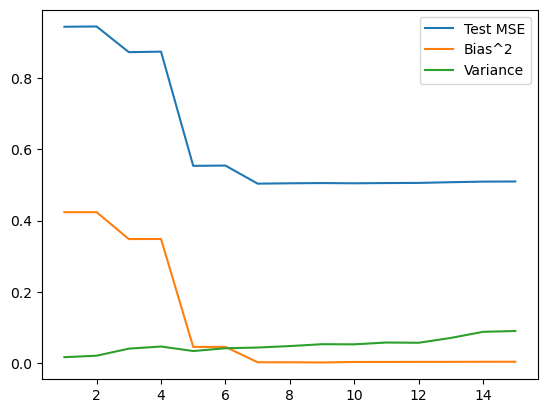

In [105]:
x_axis = list(range(1,m+1))

plt.plot(x_axis, avg_testMSE, label='Test MSE')
#plt.plot(x_axis, avg_trainMSE, label='Train MSE')
plt.plot(x_axis, avg_bias_2, label='Bias^2')
plt.plot(x_axis, avg_variance, label='Variance')
#plt.plot(list(range(m)), avg_bias_2 + avg_variance, label='Bias-Variance')

plt.legend()

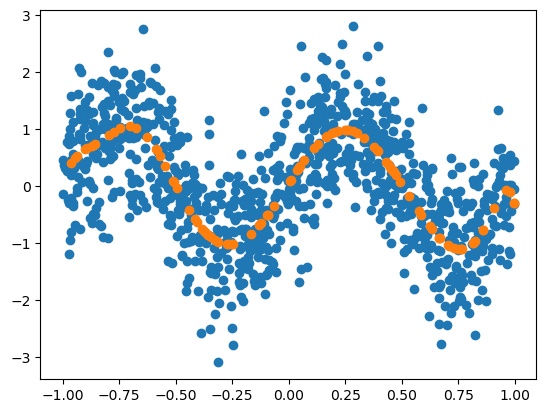

In [104]:
plt.scatter(x,y)
plt.scatter(x_test, X_test @ mw[:,9])

In [62]:
avg_testMSE

array([0.44065917, 0.44081659, 0.37832441, 0.37805767, 0.05313275,
       0.05332937, 0.00626709, 0.00627685, 0.00511545, 0.00512193,
       0.00512372, 0.00513042, 0.00514446, 0.00515531, 0.00515613])

array([-3.86687945e-04, -2.34046867e-03,  1.29464380e-03,  1.86815569e-03,
        2.43776885e-03,  9.97091483e-04, -5.34005024e-04,  3.43362708e-03,
       -5.78003804e-03,  7.31641043e-04,  3.08986130e-03, -3.64779692e-03,
        6.24780115e-03,  2.57618017e-03,  1.62345497e-03, -1.04806204e-04,
        2.92410033e-03, -1.36446017e-03,  1.98991558e-03,  8.12824527e-03,
        4.13950625e-03,  1.68145224e-03,  8.86277816e-03, -5.78249269e-03,
        4.38971355e-03, -3.37650247e-04, -5.35044812e-04, -9.30085917e-04,
        2.56273605e-03, -9.23013819e-04,  3.11660773e-03, -1.55165725e-03,
        2.74168363e-03, -4.32442593e-03,  4.50627312e-03,  3.74708765e-03,
        2.83197427e-03, -6.26848049e-03,  4.64437926e-04,  1.99922271e-03,
        3.85887411e-03,  3.46961076e-03,  1.36284723e-03, -2.26715700e-03,
        2.41395212e-03,  2.04506774e-03, -5.38222033e-03, -1.38393211e-03,
        3.82255007e-03,  3.75496578e-04,  4.23344914e-03,  3.13892387e-03,
        3.63981150e-05, -

array([ 2.72853746e-03,  6.19352038e+00,  8.31712800e-02, -3.75265259e+01,
        1.29742661e-01,  4.15053246e+01, -5.42951210e+00,  1.07067303e+02,
        2.26293736e+01, -3.96293305e+02, -3.93258302e+01,  5.51317020e+02,
        3.15113103e+01, -3.71244376e+02, -9.59256722e+00,  9.89624052e+01])

array([-1.40042261e-04,  6.18248225e+00,  7.93622589e-02, -3.77368674e+01,
        1.12850856e+00,  4.77903839e+01, -1.38215368e+01,  6.60876477e+01,
        5.14321273e+01, -2.79857559e+02, -8.86272854e+01,  3.85638397e+02,
        7.29776839e+01, -2.55172570e+02, -2.31898240e+01,  6.70550818e+01])